In [291]:
#@title Installation and Imports
import numpy as np
import networkx as nx
import scipy.linalg
import torch

# !python -m pip install -U scipy
# !python -m pip install -U networkx

## Many-Body Message Formulation

The generalized message construction involving all correlation orders $\nu$\footnote{Here we have overloaded the notation $\nu$ to denote many-body interaction function, aside from its initial meaning of correlation orders.} is (cite):


$$m_i^{(t)} = \sum_{j} \nu_1(\sigma_i^{(t)}, \sigma_j^{(t)}) + \sum_{j_1,j_2} \nu_2(\sigma_i^{(t)}, \sigma_{j_1}^{(t)}, \sigma_{j_2}^{(t)}) + \cdots$$

, where $j$'s are node $i$'s neighbors and $\sigma_j^{(t)}$ is the learned representation of node $j$ for computing $\nu$-th correlation strength at layer $t$.

For modelling interactions of different body orders, we follow the format of above equation and avoid explicit message passing via spectral filters. We start by computing the 2-body interaction messages using graph convolution. This involves apply graph Fourier transform to neighboring nodes, weighting their contributions via learnable parameters, and localizing the signal transformation through $2$-order Chebyshev expansion. 

The two-body interaction component of our model captures the pairwise relationships between nodes. By incorporating node features from previous iterations, we compute the interaction messages as follows:


$${X}^{(t)} = {U}^\top g_{\theta_2}({\Lambda}) {U} {H}^{(t-1)}$$

where ${X}^{(t)}$ represents the two-body interaction matrix at iteration $t$, $U$ is the matrix of eigenvectors of $G$'s normalized Laplacian. The function $g_{\theta_2}({\Lambda})$ denotes a second-order Chebyshev polynomial expansion applied to the diagonal matrix $\Lambda$, which contains the eigenvalues of the Laplacian matrix of the graph $G$. 

Higher-order interaction message captures the complex interactions involving more than two nodes, utilizing motif-based structures for higher-order relations. We have intuition from Windowed Fourier Transform (WFT) to apply graph signal filtering to sub-graphs coming in the form of motifs with sizes of the correlation order (\textit{standardized undirected sub-graphs of a central node with $(\nu-1)$-sized neighborhoods}). The output message for each node maintains permutation invariance by explicitly enumerating (by $\eta_{\nu}$) all neighboring sets of size $k \le \nu$. 

To better localize each motif in global graph $G$, we modify the motif Laplacian to account for Ricci curvature. Edges with more negative Ricci curvature are assigned higher positive weights in the local Laplacian of $G$'s motif, reflecting more critical connections in the graph structure: 



$$L_{\text{Ricci-J}}=$$ 
\begin{cases}
    \sum_{j \neq i} \text{Ricci}(e_{i, j}) & \text{if } i = j \\
    - \text{Ricci}(e_{i, j}) & \text{if } i \neq j \\
    0 & \text{otherwise}
\end{cases}

, where $J$ is the neighbor node set of node $i$ and $j \in J$. $\mathcal{L}_{\text{Ricci-J}}$ is normalized by $D_{\text{Ricci-J}}$ that brings in the degrees of nodes from $\{i\} \cup J$ in original graph $G$.

% $A_{\text{motif-|J|}}$ is the local adjacency matrix of tree-shaped $\lvert J\rvert$-motif while $D_{\text{Ricci-J}}$ brings in the degrees of nodes from $\{i\} \cup J$ in original graph $G$. 

The higher-order message ${Y}^{(t)}$ is hence constructed as (with \underline{$\nu \ge 3$}):


$${Y}^{(t)}_{i} = \prod_{k=3}^{\nu} \sum_{\substack{J \subseteq \eta(N(i)) \cup \{i\} \\ |J| = k}} {U}_k^\top g_{\theta_{k}}(\Lambda_{\text{Ricci-J}}) {U}_k {H}^{(t-1)}_{J}$$

, where $\eta$ is the enumeration of element sets from the neighbors of node $i$. $U_{k}^\top$ is the inverse or transpose of eigenvectors of $\mathcal{L}_{\text{Ricci-J}}$. And $g_{\theta_{k}}(\Lambda_{\text{Ricci-J}})$ term is defined as:

% We can make learnable Ricci curvatures using radial basis functions when edge attributes are available; otherwise, we may precompute and rely on the Ricci curvatures for the selected edges of $v_i$. 
\begin{equation}
g_{\theta_{k}}(\Lambda_{\text{Ricci-J}}) = \sum_{k'=1}^{k} \theta_{k,k'} T_{k'}(\widetilde{\Lambda_{\text{Ricci-J}}})
\end{equation}

where $\widetilde{\Lambda_{\text{Ricci-J}}} = \frac{2\Lambda_{\text{Ricci-J}}}{\lambda_{\text{Ricci-J}}} - I_{\lvert J \rvert}$ and $\Lambda_{\text{Ricci-J}}$ is the eigenvalues of $\lvert J \rvert$-motif's Laplacian $\mathcal{L}_{\text{Ricci-J}}$ where the curvatures are obtained from the edge set $\mathcal{E}_{i, J} \coloneqq \{ e_{i, j} \mid j \in J \}$ with respect to $G$, with $\lambda_{\text{Ricci-J}}$ representing the largest eigenvalue of the Laplacian, and $\theta_{k,k'}$ is the $k'$-th coefficient of the $k$-order Chebyshev polynomials. 


And the feature update equation, which updates the node features by combining the self-features and aggregated messages from neighbors, incorporating a residual connection (\underline{$0$-th order interaction}).

$${h}_i^{(t)} = {h}_i^{(t-1)} + {W}^{(t)} m^{(t)}_i =  {h}_i^{(t-1)} + {W}_{x, \text{sym}}^{(t)}{X}^{(t)}_{i} + {W}_{y, \text{sym}}^{(t)}{Y}_i^{(t)}$$

where ${W}^{(t)}_{\text{x,sym}}$ and ${W}_{\text{y,sym}}^{(t)}$ are symmetrized before being applied on messages for energy preservation (cite) given that ${X}^{(t)}$ and ${Y}^{(t)}$ have already had the output dimension due to $g_{\theta}$'s, and hence ${W}^{(t)}$'s are square matrices. 


In [341]:
# Precompute the eigenvectors of motifs of sizes ranging from 2 to n (tree-like: one root with n-1 leaves)
def precompute_eigenvectors(n):
    U = {}
    V = {}
    for i in range(2, n + 1):
        motif_graph = nx.star_graph(i - 1)
        laplacian_matrix = nx.laplacian_matrix(motif_graph).toarray()
        norm_lm = nx.normalized_laplacian_matrix(motif_graph).toarray()
        print(i, norm_lm)
        eigenvalues, eigenvectors = scipy.linalg.eigh(norm_lm)
        U[i] = torch.linalg.inv(torch.from_numpy(eigenvectors).to(dtype=torch.float32))  # Transform to inverse of eigenvectors for easier Fourier transform
        V[i] = torch.tensor(eigenvalues)
    return U, V

# Example usage:
n = 6  # The size of the motif
U, V = precompute_eigenvectors(n)

# Print the results
print("Eigenvectors U:", U)
print("Eigenvalues V:", V)

2 [[ 1. -1.]
 [-1.  1.]]
3 [[ 1.         -0.70710678 -0.70710678]
 [-0.70710678  1.          0.        ]
 [-0.70710678  0.          1.        ]]
4 [[ 1.         -0.57735027 -0.57735027 -0.57735027]
 [-0.57735027  1.          0.          0.        ]
 [-0.57735027  0.          1.          0.        ]
 [-0.57735027  0.          0.          1.        ]]
5 [[ 1.  -0.5 -0.5 -0.5 -0.5]
 [-0.5  1.   0.   0.   0. ]
 [-0.5  0.   1.   0.   0. ]
 [-0.5  0.   0.   1.   0. ]
 [-0.5  0.   0.   0.   1. ]]
6 [[ 1.        -0.4472136 -0.4472136 -0.4472136 -0.4472136 -0.4472136]
 [-0.4472136  1.         0.         0.         0.         0.       ]
 [-0.4472136  0.         1.         0.         0.         0.       ]
 [-0.4472136  0.         0.         1.         0.         0.       ]
 [-0.4472136  0.         0.         0.         1.         0.       ]
 [-0.4472136  0.         0.         0.         0.         1.       ]]
Eigenvectors U: {2: tensor([[-0.7071, -0.7071],
        [-0.7071,  0.7071]]), 3: tensor(

## Many-body Layer Definition

In [339]:
#@title Many-body MPNNConv Layer

import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.init as init
from torch_geometric.nn import ChebConv, GCNConv
from torch_geometric.utils import to_networkx, to_scipy_sparse_matrix, add_self_loops, get_laplacian, to_dense_adj


class ManyBodyMPNNConv(nn.Module):
    def __init__(self, in_channels, out_channels, max_order, edge_feature_dim, K=3):
        super(ManyBodyMPNNConv, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.max_order = max_order
        self.K = K
        self.U, self.V = self.precompute_motif_eigenvectors(max_order + 1)

        self.W_cheb = nn.ParameterList([nn.Parameter(torch.randn(out_channels, in_channels, K)) for _ in range(max_order)])
        self.W_cheb_motif = nn.ParameterList([nn.Parameter(torch.randn(in_channels, k, K)) for k in range(2, max_order+1)])
        self.W_msg = nn.Linear(in_channels, out_channels)

    @staticmethod
    def precompute_motif_eigenvectors(n):
        U, V = {}, {}
        for i in range(2, n + 1):
            motif_graph = nx.star_graph(i - 1)
            laplacian_matrix = nx.laplacian_matrix(motif_graph).toarray()
            eigenvalues, eigenvectors = scipy.linalg.eigh(laplacian_matrix)
            U[i] = torch.linalg.inv(torch.tensor(eigenvectors, dtype=torch.float))
            V[i] = torch.tensor(eigenvalues, dtype=torch.float)
        return U, V

    def chebyshev_expansion(self, x, K):
        T_0, T_1 = torch.ones_like(x), x
        expansion = [T_0, T_1]
        for k in range(2, K + 1):
            T_k = 2 * x * T_1 - T_0
            expansion.append(T_k)
            T_0, T_1 = T_1, T_k
        return torch.stack(expansion, dim=-1)

    def compute_dirichlet_energy(self, signal, L_dense):
        # Compute Dirichlet energy = signal^T * L * signal
        energy = torch.trace(torch.matmul(signal.t(), torch.matmul(L_dense, signal)))
        return energy
        
    def apply_chebyshev(self, L, X, K):
        X_0 = X
        X_1 = torch.matmul(L, X)
        result = self.W_cheb[0][:, :, 0].unsqueeze(1) * X_0 + self.W_cheb[0][:, :, 1].unsqueeze(1) * X_1
        for k in range(2, K):
            X_k = 2 * torch.matmul(L, X_1) - X_0
            result += self.W_cheb[0][:, :, k].unsqueeze(1) * X_k
            X_0, X_1 = X_1, X_k
        return result

    def higher_order_interaction(self, H, edge_index):
        Y_order_contributions = []

        # Initialize the output feature matrix
        Y = torch.ones_like(H)
        
        # Iterate through orders from 2 to max_order
        for order in range(2, self.max_order + 1):
            # Retrieve the precomputed eigenvectors U_k and eigenvalues for the current order
            U_k = self.U[order].to(H.device)
            lambda_k = self.V[order].to(H.device)

            # Scale the eigenvalues for Chebyshev expansion and perform the expansion
            scaled_eigenvalues = 2 * lambda_k / lambda_k.max() - 1
            T_k = self.chebyshev_expansion(scaled_eigenvalues, self.K)
            
            # Apply the filter defined by the Chebyshev expansion
            for i in range(self.K):
                # Chebyshev polynomial of degree i on the Laplacian, weighted by W_cheb
                filter_response = torch.matmul(U_k, torch.matmul(torch.diag(T_k[:, i]), U_k.t()))
                weights = self.W_cheb_motif[order-2][:, :, i]  # Assuming this needs to align with `result`
                result = torch.einsum("ni,ik->ni", H, torch.matmul(weights, filter_response.t()))
                Y += result

            Y_order_contributions.append(Y.detach().clone())

        return Y, Y_order_contributions

    def forward(self, H, edge_index, edge_features=None):
        # Compute Laplacian
        edge_index, edge_weight = add_self_loops(edge_index, num_nodes=H.size(0))
        edge_weight = torch.ones(edge_index.size(1), device=H.device)
        L = get_laplacian(edge_index, edge_weight, normalization='sym', dtype=torch.float, num_nodes=H.size(0))

        L_dense = to_dense_adj(L[0], edge_attr=L[1], max_num_nodes=H.size(0)).squeeze(0)
        L_scaled = 2 * L_dense - torch.eye(L_dense.size(0), device=H.device)

        # Direct interaction via a custom Chebyshev operation
        X_2 = self.apply_chebyshev(L_scaled, H, self.K).transpose(0, 1).mean(-1)
        # Higher-order interactions
        m, Y_order_contributions = self.higher_order_interaction(H, edge_index)

        # Compute Dirichlet energy for each order
        with torch.no_grad():
            # dirichlet_energies = [self.compute_dirichlet_energy(m_i, L_dense).item() for m_i in [X_2] + Y_order_contributions]
            dirichlet_energies = [self.compute_dirichlet_energy(m_i, L_dense).item() for m_i in Y_order_contributions]
        
        # for i, energy in enumerate(dirichlet_energies):
        #     print(f"Dirichlet energy for order {i + 2}: {energy.item()}")
        
        # Combine direct and higher-order interactions
        H_next = X_2 + self.W_msg(m)
        return H_next, dirichlet_energies

    def __initialize_weights(self):
        for w in self.W_cheb:
            init.kaiming_uniform_(w, a=np.sqrt(5))
        for w in self.W_cheb_motif:
            init.kaiming_uniform_(w, a=np.sqrt(5))

        init.kaiming_uniform_(self.W_msg.weight, a=np.sqrt(5))
        init.zeros_(self.W_msg.bias)


# Dummy data to illustrate usage
num_nodes = 10
in_channels = 4
out_channels = 12
max_order = 3
edge_feature_dim = 1
batch_size = 2

# Instantiate the layer with the learnable_ricci set to True or False based on your setup
layer = ManyBodyMPNNConv(in_channels, out_channels, max_order, edge_feature_dim)

# Dummy node feature matrix
H = torch.randn(num_nodes, in_channels)

# Generate a dummy sparse edge index for a fully-connected graph for simplicity
edge_index = torch.combinations(torch.arange(num_nodes), 2).t()

# Simulate edge features if needed
edge_features = torch.randint(0, 10, (edge_index.size(1), edge_feature_dim)).to(torch.float32)

# Adapt the model call to the new API. Note: Adjust num_nodes if batching logic is different.
H_next, _ = layer(H, edge_index, edge_features=edge_features)

print("Input dimensions:", H.shape)
print("Output dimensions:", H_next.shape)

Input dimensions: torch.Size([10, 4])
Output dimensions: torch.Size([10, 12])


In [340]:
#@title Benchmark MPNNConv Computation Speed
from torch.autograd import profiler

from torch_geometric.datasets import ZINC
from torch_geometric.loader import DataLoader


def bm_load_zinc_dataset(batch_size=32):
    train_dataset = ZINC(root='/scratch-ssd/$USER/data/ZINC', split='train')
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    return train_loader

class ManyBodyMPNNConvBenchmark(ManyBodyMPNNConv):
    def __init__(self, in_channels, out_channels, max_order, edge_feature_dim):
        super(ManyBodyMPNNConvBenchmark, self).__init__(in_channels, out_channels, max_order, edge_feature_dim)

    def forward(self, H, edge_index, edge_features=None):
        # Compute Laplacian
        edge_index, edge_weight = add_self_loops(edge_index, num_nodes=H.size(0))
        edge_weight = torch.ones(edge_index.size(1), device=H.device)
        L = get_laplacian(edge_index, edge_weight, normalization='sym', dtype=torch.float, num_nodes=H.size(0))

        L_dense = to_dense_adj(L[0], edge_attr=L[1], max_num_nodes=H.size(0)).squeeze(0)
        L_scaled = 2 * L_dense - torch.eye(L_dense.size(0), device=H.device)

        # Direct interaction via a custom Chebyshev operation
        X_2 = self.apply_chebyshev(L_scaled, H, self.K).transpose(0, 1).mean(-1)
        # Higher-order interactions
        m, Y_order_contributions = self.higher_order_interaction(H, edge_index)

        # Compute Dirichlet energy for each order
        with torch.no_grad():
            # dirichlet_energies = [self.compute_dirichlet_energy(m_i, L_dense).item() for m_i in [X_2] + Y_order_contributions]
            dirichlet_energies = [self.compute_dirichlet_energy(m_i, L_dense).item() for m_i in Y_order_contributions]
        
        # for i, energy in enumerate(dirichlet_energies):
        #     print(f"Dirichlet energy for order {i + 2}: {energy.item()}")
        
        # Combine direct and higher-order interactions
        H_next = X_2 + self.W_msg(m)
        return H_next, dirichlet_energies



# Actual data from train_loader (ZINC)
batch_size = 32
train_loader = bm_load_zinc_dataset(batch_size)
data = next(iter(train_loader))

num_nodes = data.num_nodes
in_channels = 1
out_channels = 12
max_order = 5
edge_feature_dim = 1

# Instantiate the benchmark layer with the learnable_ricci set to True
layer_benchmark = ManyBodyMPNNConvBenchmark(in_channels, out_channels, max_order, edge_feature_dim)
H = torch.randn(num_nodes, in_channels)
edge_index = data.edge_index
edge_features = data.edge_attr.to(torch.float32)

# Wrap the forward call within the profiler context manager
with profiler.profile(with_stack=True, profile_memory=True, use_cuda=torch.cuda.is_available()) as prof:
    H_next = layer_benchmark(H, edge_index, edge_features=edge_features)

# Print the profiling results
print(prof.key_averages().table(sort_by="cuda_time_total" if torch.cuda.is_available() else "cpu_time_total", row_limit=10))

STAGE:2024-04-09 16:53:01 1677308:1677308 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-04-09 16:53:01 1677308:1677308 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-04-09 16:53:01 1677308:1677308 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem    # of Calls  
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                 aten::matmul         1.75%     558.000us        11.05%       3.520ms      76.522us     728.000us         3.73%       3.811ms      82.848us      18.13 Kb           0 b            46  
                     aten::mm         5.44%       1.732ms         8.67%       2.761ms      60.022us       1.860ms         9.54%       3.083ms      67.022us      18.13 Kb      17.97 Kb            46  

## Experiments on ZINC and Ablation Studies

Run Many-body MPNN (and GCN, GatedGCN, GraphSage) on ZINC (graph classification) and compare performances.

In [307]:
#@title Load ZINC Dataset
import torch
# from torch_scatter import scatter_add
from torch_geometric.datasets import ZINC
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import BaseTransform
from torch_geometric.utils import to_networkx, add_self_loops, get_laplacian, to_dense_adj

import networkx as nx
import numpy as np

def load_zinc_dataset_subset(batch_size=32, subset_size=1000):
    # Load the full datasets
    train_dataset_full = ZINC(root='/scratch-ssd/$USER/data/ZINC', split='train')
    val_dataset_full = ZINC(root='/scratch-ssd/$USER/data/ZINC', split='val')
    test_dataset_full = ZINC(root='/scratch-ssd/$USER/data/ZINC', split='test')

    # Select a subset of each dataset
    train_dataset = train_dataset_full[:subset_size]
    val_dataset = val_dataset_full[:subset_size]
    test_dataset = test_dataset_full[:subset_size]

    # Create DataLoaders for each subset
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

# Example usage
batch_size = 32
subset_size = 20000  # For faster training and benchmarking.
train_loader, val_loader, test_loader = load_zinc_dataset_subset(batch_size, subset_size)

In [330]:
#@title Many-Body MPNN, GCN, GraphSage, ChebNet Models
import torch
import torch.nn.functional as F
from torch.nn import ModuleList, BatchNorm1d, Linear
from torch_geometric.nn import (
    ChebConv,
    GCNConv,
    SAGEConv,
    GatedGraphConv,
    global_mean_pool,
)


class BaseGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, conv_layer_type, dropout=0.5, *args, **kwargs):
        super(BaseGNN, self).__init__()
        self.convs = ModuleList()
        self.bns = ModuleList()
        self.dropout = dropout

        self.convs.append(conv_layer_type(in_channels, hidden_channels, *args, **kwargs))
        self.bns.append(BatchNorm1d(hidden_channels))
        for _ in range(1, num_layers):
            self.convs.append(conv_layer_type(hidden_channels, hidden_channels, *args, **kwargs))
            self.bns.append(BatchNorm1d(hidden_channels))

        self.lin1 = Linear(hidden_channels, out_channels)

        self.__initialize_weights()

    def forward(self, data, use_pooling=True):
        x, edge_index, batch = data.x.to(torch.float32), data.edge_index, data.batch
        if data.edge_attr is not None:
            edge_features = data.edge_attr.unsqueeze(1).to(torch.float32)
        else:
            edge_features = None

        energies_list = []

        for i, conv in enumerate(self.convs):
            if isinstance(conv, ManyBodyMPNNConv):
                x, energies = conv(x, edge_index)
                energies_list.append(energies)
            else:
                x = conv(x, edge_index, edge_features) if edge_features is not None else conv(x, edge_index)
            x = self.bns[i](x)
            x = F.leaky_relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        if use_pooling:
            x = global_mean_pool(x, batch)
        x = self.lin1(x)
        return x, energies_list

    def __initialize_weights(self):
        for conv in self.convs:
            if hasattr(conv, 'weight'):
                nn.init.xavier_uniform_(conv.weight)
            if hasattr(conv, 'bias') and conv.bias is not None:
                nn.init.zeros_(conv.bias)
        nn.init.xavier_uniform_(self.lin1.weight)
        nn.init.zeros_(self.lin1.bias)

class ManyBodyMPNN(BaseGNN):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, max_order, edge_feature_dim, K=3, dropout=0.5):
        super(ManyBodyMPNN, self).__init__(in_channels, hidden_channels, out_channels,
                                  num_layers, ManyBodyMPNNConv, dropout, max_order, edge_feature_dim, K)

class GCN(BaseGNN):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout=0.5):
        super(GCN, self).__init__(in_channels, hidden_channels, out_channels, num_layers, GCNConv, dropout)

class GraphSage(BaseGNN):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout=0.5):
        super(GraphSage, self).__init__(in_channels, hidden_channels, out_channels, num_layers, SAGEConv, dropout)

class ChebNet(BaseGNN):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, K, dropout=0.5):
        super(ChebNet, self).__init__(in_channels, hidden_channels, out_channels, num_layers, ChebConv, dropout, K)

In [331]:
#@title (Test) Training Loops
in_channels = 1
hidden_channels = 32
output_channels = 1
num_of_layers = 4
max_order = 4
edge_feature_dim = 1
K = 3  # Chebyshev filter size

models = {
    "GCN": GCN(in_channels, hidden_channels, output_channels, num_of_layers),
    "ChebNet": ChebNet(in_channels, hidden_channels, output_channels, num_of_layers, K),
    "ManyBodyMPNN": ManyBodyMPNN(in_channels, hidden_channels, output_channels, num_of_layers,
                                 max_order, edge_feature_dim, K),
}

for data in train_loader:
    for name, model in models.items():
        out, _ = model(data)
        loss = torch.nn.functional.mse_loss(out.squeeze(), data.y)
        print(name, loss)
    break
# DataBatch(x=[747, 1], edge_index=[2, 1610], edge_attr=[1610], y=[32], batch=[747], ptr=[33])

GCN tensor(3.5480, grad_fn=<MseLossBackward0>)
ChebNet tensor(3.5020, grad_fn=<MseLossBackward0>)
ManyBodyMPNN tensor(3.1724, grad_fn=<MseLossBackward0>)


In [332]:
#@title Model Instantiation
in_channels = 1
hidden_channels = 8
output_channels = 1
num_of_layers = 3
max_order = 5
edge_feature_dim = 1
K = 4  # Chebyshev filter size

models = {
    "GCN": GCN(in_channels, hidden_channels, output_channels, num_of_layers),
    "ChebNet": ChebNet(in_channels, hidden_channels, output_channels, num_of_layers, K),
    "ManyBodyMPNN": ManyBodyMPNN(in_channels, hidden_channels, output_channels, num_of_layers,
                                 max_order, edge_feature_dim, K),
}

In [333]:
#@title Training Loops
import torch.optim as optim
from torch.nn.functional import mse_loss
from tqdm.auto import tqdm

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def compute_loss(pred, target):
    return mse_loss(pred.squeeze(), target)

def evaluate(model, test_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0
    with torch.no_grad():
        for data in tqdm(test_loader, desc="Evaluating", leave=False):
            data = data.to(device)
            out, _ = model(data)
            loss = compute_loss(out, data.y)
            total_loss += loss.item() * data.num_graphs
    avg_loss = total_loss / len(test_loader.dataset)
    print(f'Average Test Loss: {avg_loss:.4f}')
    return avg_loss

def train(model, train_loader, val_loader, device, n_epochs=50):
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    model.train()
    model.to(device)  # Move model to the appropriate device

    for epoch in tqdm(range(1, n_epochs + 1), desc="Training Epochs"):
        epoch_loss = 0
        for data in tqdm(train_loader, desc=f"Epoch {epoch}", leave=False):
            # print(data.x)
            data = data.to(device)
            optimizer.zero_grad()
            out, _ = model(data)
            loss = compute_loss(out, data.y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
            optimizer.step()
            epoch_loss += loss.item() * data.num_graphs

        # Log training loss and validate the model's performance
        train_loss = epoch_loss / len(train_loader.dataset)
        val_loss = evaluate(model, val_loader, device)
        tqdm.write(f'Epoch: {epoch}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    return train_loss, val_loss

In [334]:
n_epochs = 5

for name, model in models.items():
    # Run GCN and GraphSage for comparison
    if name != "ManyBodyMPNN":
        continue
    print(f"Training {name}")
    train_loss, val_loss = train(model, train_loader, val_loader, device, n_epochs=n_epochs)
    test_loss = evaluate(model, test_loader, device)
    print(f"{name} - Final Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}")

Training ManyBodyMPNN


Training Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

Average Test Loss: 3.5123
Epoch: 1, Training Loss: 3.6556, Validation Loss: 3.5123


Epoch 2:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

Average Test Loss: 2.5700
Epoch: 2, Training Loss: 3.1976, Validation Loss: 2.5700


Epoch 3:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

Average Test Loss: 3.4275
Epoch: 3, Training Loss: 2.8125, Validation Loss: 3.4275


Epoch 4:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

Average Test Loss: 2.3035
Epoch: 4, Training Loss: 2.6164, Validation Loss: 2.3035


Epoch 5:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

Average Test Loss: 2.0690
Epoch: 5, Training Loss: 2.4265, Validation Loss: 2.0690


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Average Test Loss: 1.9276
ManyBodyMPNN - Final Training Loss: 2.4265, Validation Loss: 2.0690, Test Loss: 1.9276


In [ ]:
n_epochs = 5

for name, model in models.items():
    # Run GCN and GraphSage for comparison
    if name != "ChebNet":
        continue
    print(f"Training {name}")
    train_loss, val_loss = train(model, train_loader, val_loader, device, n_epochs=n_epochs)
    test_loss = evaluate(model, test_loader, device)
    print(f"{name} - Final Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}")

## Potential Energy Evolution

In [336]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import get_laplacian
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to compute Dirichlet energy
def compute_dirichlet_energy(signal, edge_index, device):
    lap_indices, lap_values = get_laplacian(edge_index, normalization="sym", dtype=torch.float)

    laplacian_sparse = torch.sparse_coo_tensor(lap_indices, lap_values).to(device)
    
    if signal.dim() == 1:
        signal = signal.unsqueeze(1)  # Make it (N, 1) if it's just (N,)

    # Compute Dirichlet energy = signal^T * L * signal
    energy = torch.trace(torch.matmul(signal.t(), torch.sparse.mm(laplacian_sparse, signal)))

    return energy.item()

def train_and_compute_energy(model, data, optimizer, epochs=50):
    model.train()
    test_accuracies = []  
    dirichlet_energies = []
    body_term_energies = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        out, energies_list = model(data, use_pooling=False)
        body_term_energies.append(energies_list)
        loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        energy = compute_dirichlet_energy(out.detach(), data.edge_index, device)
        dirichlet_energies.append(energy)

        # Evaluate test accuracy
        model.eval()
        out, _ = model(data, use_pooling=False)
        _, pred = out.max(dim=1)
        correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
        accuracy = correct / data.test_mask.sum().item()
        test_accuracies.append(accuracy)  # Log test accuracy

        if epoch % 10 == 0:
            print(f'Epoch {epoch}: Test Accuracy = {accuracy:.4f}, Dirichlet Energy = {energy}')

    print("Training completed")
    return test_accuracies, dirichlet_energies, body_term_energies

# Loading Cora dataset
dataset = Planetoid(root='./data/', name='Cora')
data = dataset[0].to(device)

num_of_layers = 4
max_order = 4
edge_feature_dim = 1
K = 3  # Chebyshev filter size

models = {
    # "GCN": GCN(dataset.num_node_features, 16, dataset.num_classes, num_of_layers),
    "ChebNet": ChebNet(dataset.num_node_features, 16, dataset.num_classes, num_of_layers, K),
    "ManyBodyMPNN": ManyBodyMPNN(dataset.num_node_features, 16, dataset.num_classes, num_of_layers,
                                 max_order, edge_feature_dim, K),
}

test_accuracies_dict = {}
dirichlet_energies_dict = {}
body_term_energies_dict = {}

for name, model in models.items():
    print(f"Training {name}")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    accuracies, energies, body_term_energies = train_and_compute_energy(model, data, optimizer, epochs=300)
    test_accuracies_dict[name] = accuracies
    dirichlet_energies_dict[name] = energies
    body_term_energies_dict[name] = body_term_energies

Training ChebNet
Epoch 0: Test Accuracy = 0.2800, Dirichlet Energy = 26287.03515625
Epoch 10: Test Accuracy = 0.7220, Dirichlet Energy = 32172.94140625
Epoch 20: Test Accuracy = 0.6660, Dirichlet Energy = 110903.40625
Epoch 30: Test Accuracy = 0.6250, Dirichlet Energy = 110456.2578125
Epoch 40: Test Accuracy = 0.6480, Dirichlet Energy = 121594.1484375
Epoch 50: Test Accuracy = 0.6570, Dirichlet Energy = 136162.34375
Epoch 60: Test Accuracy = 0.6550, Dirichlet Energy = 149266.125
Epoch 70: Test Accuracy = 0.6560, Dirichlet Energy = 158224.125
Epoch 80: Test Accuracy = 0.6530, Dirichlet Energy = 164030.015625
Epoch 90: Test Accuracy = 0.6520, Dirichlet Energy = 167983.734375
Epoch 100: Test Accuracy = 0.6500, Dirichlet Energy = 170982.265625
Epoch 110: Test Accuracy = 0.6490, Dirichlet Energy = 173500.6875
Epoch 120: Test Accuracy = 0.6500, Dirichlet Energy = 175766.34375
Epoch 130: Test Accuracy = 0.6490, Dirichlet Energy = 177882.140625
Epoch 140: Test Accuracy = 0.6500, Dirichlet Ener

KeyboardInterrupt: 

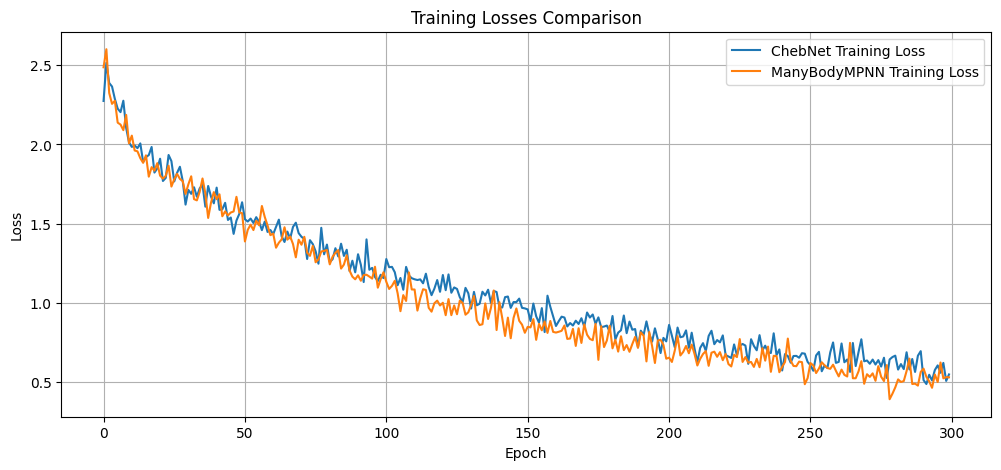

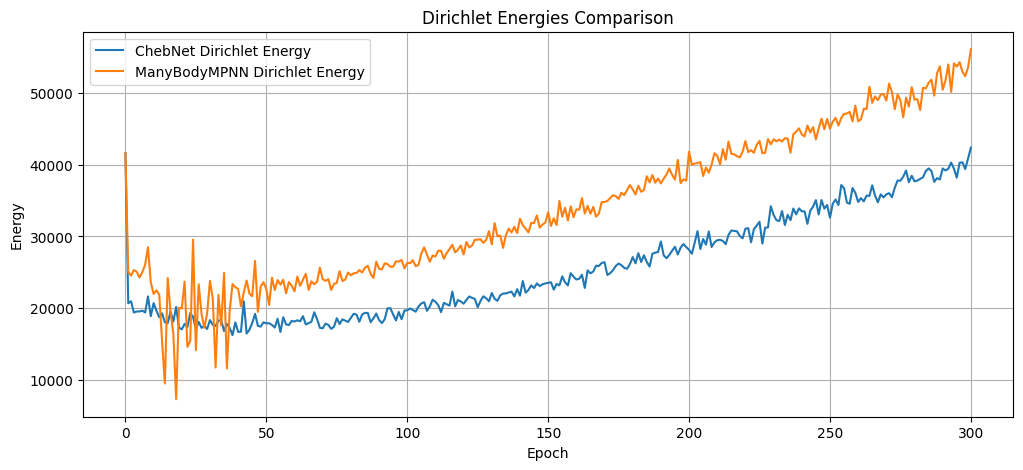

In [196]:
# The energy pattern is sort of undeterministic.
plt.figure(figsize=(12, 5))
for name, accs in test_accuracies_dict.items():
    plt.plot(accs, label=f'{name} Test Accuracy')
plt.title('Test Accuracies Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Dirichlet Energies of all models together
plt.figure(figsize=(12, 5))
for name, energies in dirichlet_energies_dict.items():
    plt.plot(energies, label=f'{name} Dirichlet Energy')
plt.title('Dirichlet Energies Comparison')
plt.xlabel('Epoch')
plt.ylabel('Energy')
plt.legend()
plt.grid(True)
plt.show()

In [241]:
from torch_geometric.data import Data

def create_heterophilic_graph_with_splits(num_nodes, num_classes, num_features, avg_degree, heterophily_ratio, train_split=0.7):
    # Node features and labels
    x = torch.randn(num_nodes, num_features)  # Random features
    y = torch.randint(0, num_classes, (num_nodes,))  # Random class labels
    
    # Edge generation for heterophily
    edges = []
    for _ in range(num_nodes * avg_degree // 2):  # Approximation to achieve the desired average degree
        node_a = np.random.randint(0, num_nodes)
        if np.random.rand() < heterophily_ratio:  # Heterophilic connection
            node_b = np.random.choice(np.where(y != y[node_a])[0])
        else:  # Homophilic connection
            node_b = np.random.choice(np.where(y == y[node_a])[0])
        edges.append([node_a, node_b])
        edges.append([node_b, node_a])  # Assuming undirected graph
    
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    
    # Split nodes into train and test
    num_train = int(num_nodes * train_split)
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    
    # Randomly select nodes for training, the rest for testing
    train_indices = torch.randperm(num_nodes)[:num_train]
    test_indices = torch.randperm(num_nodes)[num_train:]
    
    train_mask[train_indices] = True
    test_mask[test_indices] = True
    
    # Create PyG Data object including the masks
    data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, test_mask=test_mask, num_node_features=num_features, num_classes=num_classes)
    
    return data

Epoch 0: Test Accuracy = 0.0443, Dirichlet Energy = 133328.71875
Epoch 10: Test Accuracy = 0.0487, Dirichlet Energy = 12.927431106567383
Epoch 20: Test Accuracy = 0.0613, Dirichlet Energy = 42.71956253051758
Epoch 30: Test Accuracy = 0.0690, Dirichlet Energy = 131.4070281982422
Epoch 40: Test Accuracy = 0.0860, Dirichlet Energy = 1007.3943481445312
Epoch 50: Test Accuracy = 0.1207, Dirichlet Energy = 10502.921875
Epoch 60: Test Accuracy = 0.1393, Dirichlet Energy = 45602.46875
Epoch 70: Test Accuracy = 0.1707, Dirichlet Energy = 93996.125
Epoch 80: Test Accuracy = 0.1890, Dirichlet Energy = 122740.2109375
Epoch 90: Test Accuracy = 0.2107, Dirichlet Energy = 153129.78125
Epoch 100: Test Accuracy = 0.2427, Dirichlet Energy = 197643.328125
Epoch 110: Test Accuracy = 0.2363, Dirichlet Energy = 235521.765625
Epoch 120: Test Accuracy = 0.2750, Dirichlet Energy = 286119.28125
Epoch 130: Test Accuracy = 0.2850, Dirichlet Energy = 327568.1875
Epoch 140: Test Accuracy = 0.3063, Dirichlet Energy 

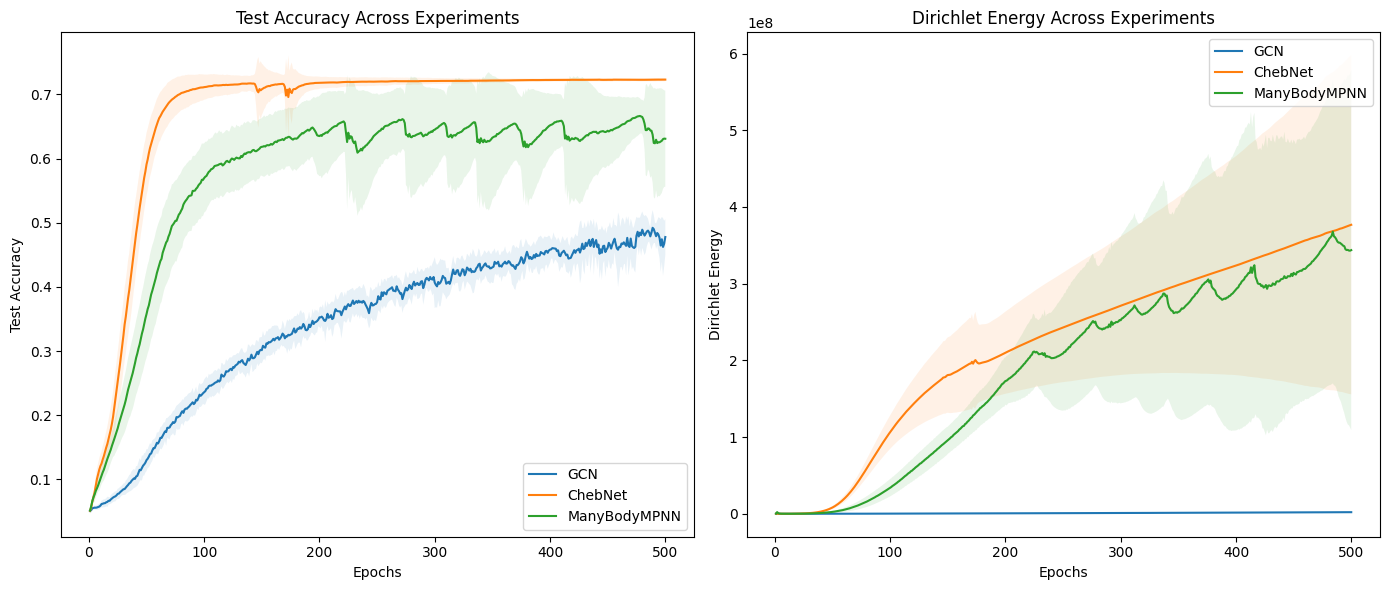

In [242]:
from datetime import datetime

data_syn_hetero = create_heterophilic_graph_with_splits(num_nodes=10000, num_classes=5, num_features=1433, avg_degree=10, heterophily_ratio=0.8).to(device)  # most hetero-suitable for ChebNet

num_of_layers = 4
max_order = 4
edge_feature_dim = 1
K = 3  # Chebyshev filter size
num_experiments = 10
epochs = 500

models = {
    "GCN": lambda :GCN(data_syn_hetero.num_node_features, 16, data_syn_hetero.num_classes, num_of_layers),
    "ChebNet": lambda :ChebNet(data_syn_hetero.num_node_features, 16, data_syn_hetero.num_classes, num_of_layers, K),
    "ManyBodyMPNN": lambda :ManyBodyMPNN(data_syn_hetero.num_node_features, 16, data_syn_hetero.num_classes, num_of_layers, max_order, edge_feature_dim, K),
}

test_accuracies_dict = {name: [] for name in models}
dirichlet_energies_dict = {name: [] for name in models}
body_term_energies_dict = {name: [] for name in models}

for experiment in range(num_experiments):
    for name, Model in models.items():
        model = Model().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
        accuracies, energies, body_term_energies = train_and_compute_energy(model, data_syn_hetero, optimizer, epochs=epochs)
        test_accuracies_dict[name].append(accuracies)
        dirichlet_energies_dict[name].append(energies)
        body_term_energies_dict[name].append(body_term_energies)
        print(f"Completed {name} for experiment {experiment + 1}")

# Plotting
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(14, 6))

# Plot for accuracies
plt.subplot(1, 2, 1)
for name in models:
    accuracies_runs = np.array(test_accuracies_dict[name])
    mean_accuracies = np.mean(accuracies_runs, axis=0)
    std_accuracies = np.std(accuracies_runs, axis=0)
    
    plt.plot(epochs_range, mean_accuracies, label=f'{name}')
    plt.fill_between(epochs_range, mean_accuracies - std_accuracies, mean_accuracies + std_accuracies, alpha=0.1)

plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Across Experiments')
plt.legend()

# Plot for energies
plt.subplot(1, 2, 2)
for name in models:
    energies_runs = np.array(dirichlet_energies_dict[name])
    mean_energies = np.mean(energies_runs, axis=0)
    std_energies = np.std(energies_runs, axis=0)
    
    plt.plot(epochs_range, mean_energies, label=f'{name}')
    plt.fill_between(epochs_range, mean_energies - std_energies, mean_energies + std_energies, alpha=0.1)

plt.xlabel('Epochs')
plt.ylabel('Dirichlet Energy')
plt.title('Dirichlet Energy Across Experiments')
plt.legend()

plt.tight_layout()

# Save the figure to a file
plt.savefig(f'./figures/hetero_acc_energies_gcn_chebnet_mpnn_{datetime.now().strftime("%Y%m%d-%H%M%S")}.png')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming body_term_energies_dict['ManyBodyMPNN'] is a numpy array with the described dimensions
# For demonstration, let's create a dummy array with similar structure
# dimensions: [10 experiments, 500 epochs, 4 components], values are random for illustration

data = np.array(body_term_energies_dict['ManyBodyMPNN'])

# Calculate means and variances for the updated data structure
means_updated = np.mean(data, axis=0)
variances_updated = np.var(data, axis=0)

# Plotting the energy growths for each of the 4 components across all 4 layers
epochs = np.arange(1, 501)
layers = ['Layer 1', 'Layer 2', 'Layer 3', 'Layer 4']

# Create 4 plots, one for each component
for component_idx in range(4):
    plt.figure(figsize=(10, 6))
    
    for layer_idx in range(4):
        plt.plot(epochs, np.log(means_updated[:, layer_idx, component_idx]), label=f'{layers[layer_idx]} Mean')
        plt.fill_between(epochs,
                         np.log(means_updated[:, layer_idx, component_idx] - np.sqrt(variances_updated[:, layer_idx, component_idx] / 10)), 
                        np.log(means_updated[:, layer_idx, component_idx] + np.sqrt(variances_updated[:, layer_idx, component_idx] / 10)), 
                         alpha=0.2, label=f'{layers[layer_idx]} Variance')
    
    plt.title(f'Energy Growth for {component_idx + 2}-Body Component Across 4 Layers Over 500 Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Energy')
    plt.legend()
    plt.grid(True)
    plt.show()

# To put in appendix

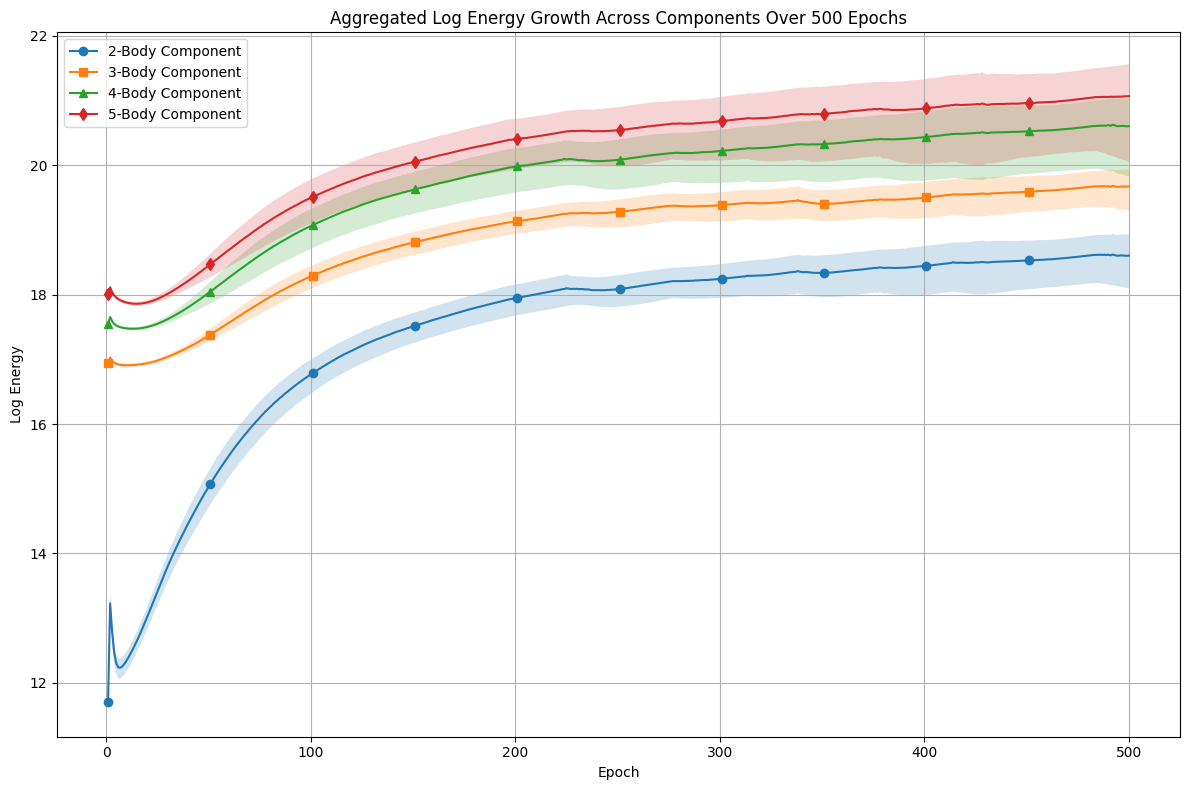

In [314]:
plt.figure(figsize=(12, 8))

# Compute the aggregated mean and standard deviation across all layers for each component
aggregated_means = np.mean(means_updated, axis=1)  # Mean across layers
aggregated_stds = np.sqrt(np.mean(variances_updated / 10, axis=1))  # Standard deviation across layers

# Different markers for each component
markers = ['o', 's', '^', 'd']  

# Plotting the aggregated mean and standard deviation for each component
for component_idx in range(4):
    # Plotting mean energy growth
    plt.plot(epochs, np.log(aggregated_means[:, component_idx]), 
             label=f'{component_idx + 2}-Body Component', marker=markers[component_idx], markevery=50, linestyle='-')
    # Plotting standard deviation as shaded area
    plt.fill_between(epochs, 
                     np.log(aggregated_means[:, component_idx] - aggregated_stds[:, component_idx]), 
                     np.log(aggregated_means[:, component_idx] + aggregated_stds[:, component_idx]), 
                     alpha=0.2)

plt.title('Aggregated Log Energy Growth Across Components Over 500 Epochs')
plt.xlabel('Epoch')
plt.ylabel('Log Energy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'./figures/log_energy_growth_per_component_{datetime.now().strftime("%Y%m%d-%H%M%S")}.png')
plt.show()

## References
GitHub Issues on torch_geometric:

* https://github.com/pyg-team/pytorch_geometric/issues/1827
* https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html
* [Forman-Ricci Curvature for Complex Networks](https://web.math.princeton.edu/~mw25/files/MWeber_poster2.pdf)
